
Running simulations for N = 1000

Running simulations for N = 10000

Results for N = 1000:
After 10 minutes: 11.87% ± 3.69% heard the rumor
After 30 minutes: 94.06% ± 1.33% heard the rumor
After 60 minutes: 98.94% ± 0.37% heard the rumor

Results for N = 10000:
After 10 minutes: 1.25% ± 0.43% heard the rumor
After 30 minutes: 82.06% ± 4.50% heard the rumor
After 60 minutes: 98.63% ± 0.19% heard the rumor

For N = 10,000:
10% threshold reached after 17 minutes
50% threshold reached after 24 minutes


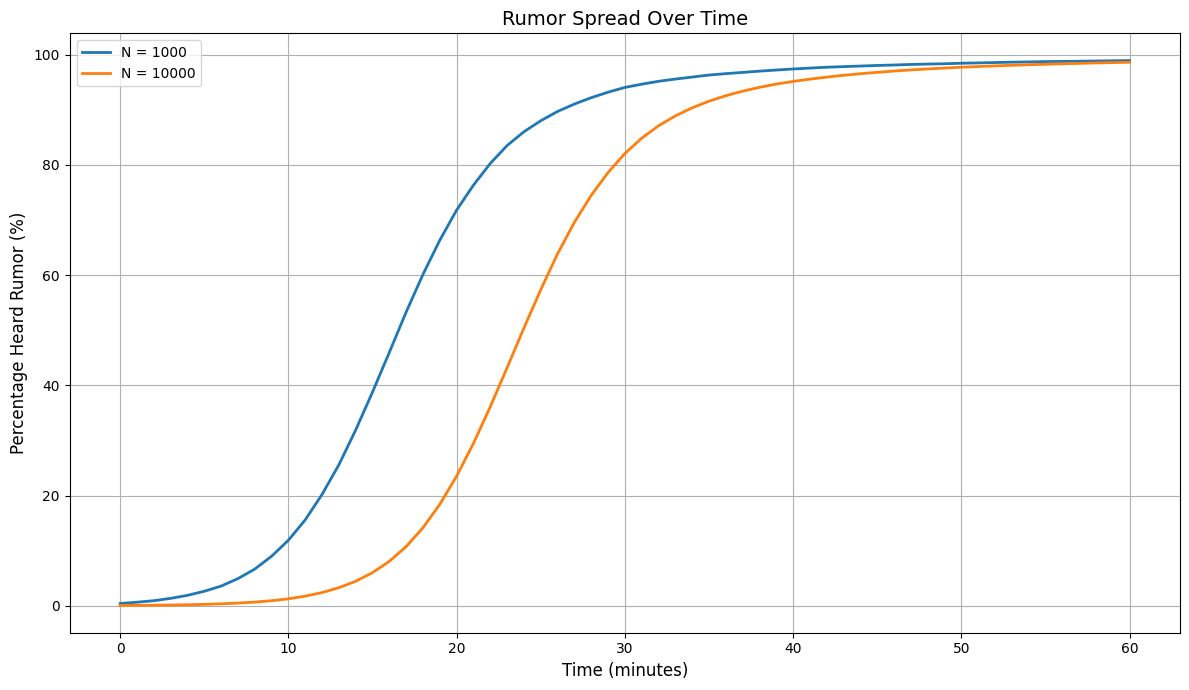

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def simulate_rumor_spread(N, T_minutes, num_simulations=30, verbose=False):
    """
    Simulate rumor spread through a conference where:
    - N participants are distributed across 4 satellite rooms
    - Participants pair up randomly each minute
    - 4 initial rumor spreaders (one in each room)
    - 50% chance of spreading the rumor when paired
    - After hearing the rumor twice, participants stop spreading it
    
    Parameters:
    - N: Number of participants (must be even)
    - T_minutes: Conference duration in minutes
    - num_simulations: Number of simulations to run
    - verbose: Print detailed output
    
    Returns:
    - avg_aware_percentages: Average percentage of participants aware of the rumor per minute
    """
    if N % 2 != 0:
        raise ValueError("N must be an even number")
    
    all_results = np.zeros((num_simulations, T_minutes + 1))
    
    for sim in range(num_simulations):
        if verbose:
            print(f"Running simulation {sim+1}/{num_simulations}")
        
        # Distribute participants to 4 rooms (ensure even numbers in each room)
        room_sizes = distribute_participants(N)
        if verbose:
            print(f"Room sizes: {room_sizes}")
        
        # Track rumor awareness (0=unaware, 1=heard once, 2=heard twice or more)
        rumor_status = np.zeros(N, dtype=int)
        
        # Track who is actively spreading the rumor
        is_spreading = np.zeros(N, dtype=bool)
        
        # Initialize 4 spreaders (one in each room)
        start_idx = 0
        for i, room_size in enumerate(room_sizes):
            # Select one person from each room to be initial spreader
            spreader_idx = start_idx
            rumor_status[spreader_idx] = 1
            is_spreading[spreader_idx] = True
            start_idx += room_size
        
        # Record initial state (% aware of rumor)
        all_results[sim, 0] = 100 * np.sum(rumor_status > 0) / N
        
        # Assign participants to rooms (store indices of participants in each room)
        rooms = []
        idx = 0
        for size in room_sizes:
            rooms.append(list(range(idx, idx + size)))
            idx += size
        
        # Simulate each minute
        for minute in range(1, T_minutes + 1):
            # For each room, randomly pair participants and potentially spread rumors
            for room_idx, participants in enumerate(rooms):
                # Shuffle participants to create random pairs
                np.random.shuffle(participants)
                
                # Process each pair
                for i in range(0, len(participants), 2):
                    person1 = participants[i]
                    person2 = participants[i + 1]
                    
                    # If person1 is spreading the rumor
                    if is_spreading[person1]:
                        # 50% chance to spread to person2
                        if np.random.random() < 0.5:
                            # Update person2's rumor status
                            if rumor_status[person2] < 2:
                                rumor_status[person2] += 1
                            
                            # Stop spreading if heard twice
                            if rumor_status[person2] == 2:
                                is_spreading[person2] = False
                            else:
                                is_spreading[person2] = True
                    
                    # If person2 is spreading the rumor
                    if is_spreading[person2]:
                        # 50% chance to spread to person1
                        if np.random.random() < 0.5:
                            # Update person1's rumor status
                            if rumor_status[person1] < 2:
                                rumor_status[person1] += 1
                            
                            # Stop spreading if heard twice
                            if rumor_status[person1] == 2:
                                is_spreading[person1] = False
                            else:
                                is_spreading[person1] = True
            
            # Record percentage of participants aware of the rumor
            aware_percent = 100 * np.sum(rumor_status > 0) / N
            all_results[sim, minute] = aware_percent
            
            # Redistribute participants among rooms randomly for next minute
            redistribute_participants(rooms, room_sizes)
    
    # Calculate average and standard deviation across all simulations
    avg_aware_percentages = np.mean(all_results, axis=0)
    std_aware_percentages = np.std(all_results, axis=0)
    
    return avg_aware_percentages, std_aware_percentages

def distribute_participants(N):
    """
    Distribute N participants into 4 satellite rooms ensuring even numbers in each room.
    Returns a list of room sizes that sum to N.
    """
    # Ensure N is even
    assert N % 2 == 0, "N must be even"
    
    # Generate 3 random numbers that are even and sum to less than N
    room_sizes = []
    remaining = N
    
    for _ in range(3):
        # Calculate max size for this room (ensure remaining rooms can have at least 2 people)
        max_size = remaining - 2 * (3 - len(room_sizes))
        
        # Generate a random even number between 2 and max_size
        size = np.random.randint(1, max_size // 2 + 1) * 2
        room_sizes.append(size)
        remaining -= size
    
    # Assign remaining participants to the last room
    room_sizes.append(remaining)
    
    # Shuffle room assignments
    np.random.shuffle(room_sizes)
    
    return room_sizes

def redistribute_participants(rooms, room_sizes):
    """
    Randomly redistribute participants among rooms while maintaining the same room sizes.
    
    Parameters:
    - rooms: List of lists containing participant indices for each room
    - room_sizes: List of room sizes
    """
    # Flatten the list of all participants
    all_participants = []
    for room in rooms:
        all_participants.extend(room)
    
    # Shuffle participants
    np.random.shuffle(all_participants)
    
    # Reassign to rooms
    idx = 0
    for room_idx, size in enumerate(room_sizes):
        rooms[room_idx] = all_participants[idx:idx+size]
        idx += size

def find_threshold_time(data, threshold_percentage):
    """Find the first minute when rumor awareness reaches or exceeds the threshold percentage"""
    for minute, percentage in enumerate(data):
        if percentage >= threshold_percentage:
            return minute
    return "Not reached"

# Define parameters
N_values = [1000, 10000]
T_values = [10, 30, 60]
num_simulations = 30

results = {}
std_devs = {}
threshold_times = {}

# Run simulations
for N in N_values:
    print(f"\nRunning simulations for N = {N}")
    
    # Find the longest time for this N value
    max_T = max(T_values)
    
    # Run simulation once with the maximum time
    results[(N, max_T)], std_devs[(N, max_T)] = simulate_rumor_spread(N, max_T, num_simulations)
    
    # Extract results for shorter times from the longer simulation
    for T in T_values:
        if T != max_T:
            results[(N, T)] = results[(N, max_T)][:T+1]
            std_devs[(N, T)] = std_devs[(N, max_T)][:T+1]
    
    # For N = 10,000, find threshold times
    if N == 10000:
        data = results[(N, max_T)]
        threshold_times[10] = find_threshold_time(data, 10)
        threshold_times[50] = find_threshold_time(data, 50)

# Display results
for N in N_values:
    print(f"\nResults for N = {N}:")
    for T in T_values:
        print(f"After {T} minutes: {results[(N, T)][T]:.2f}% ± {std_devs[(N, T)][T]:.2f}% heard the rumor")

if 10000 in N_values:
    print(f"\nFor N = 10,000:")
    print(f"10% threshold reached after {threshold_times[10]} minutes")
    print(f"50% threshold reached after {threshold_times[50]} minutes")

# Plot the results
plt.figure(figsize=(12, 7))
for N in N_values:
    max_T = max(T_values)
    plt.plot(range(max_T+1), results[(N, max_T)], label=f"N = {N}", linewidth=2)

plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Percentage Heard Rumor (%)", fontsize=12)
plt.title("Rumor Spread Over Time", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("rumor_spread.png")
plt.show()